**Description**: Shows how to use lazy linear constraints to approximate a nonlinear constraint.

**Author**: Iain Dunning

**License**: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

# Approximating a $L^2$ Ball with Linear Constraints

Consider the optimization problem

$$
\begin{alignat}{2}
\max_{\mathbf{x}} \ & \mathbf{c} \cdot \mathbf{x} \\
\text{subject to} \ & \left\| x \right\| \leq \Gamma \\
                    & x \in \mathbb{Z}^n
\end{alignat}
$$

This problem is an integer second-order cone problem, a problem class that commercial solvers have only really been able to solve efficiently in the past few years. One way to solve this problem would be to solve the continuous relaxation directly, and apply branch-and-bound to find an integer solution. A different perspective is to solve a series of linear problems where the nonlinear norm constraint is approximated by linear constraints.

We can implement the second method ourselves using JuMP's **lazy constraint callbacks**. In this method we do not provide the solver with the norm constraint directly, but instead provide a callback that will attempt to generate a new linear constraint whenever the solver finds an integer solution. Only a finite number of linear constraints are needed to approximate the norm constraint, so this algorithm should eventually terminate.

In [1]:
using JuMP
# We need to have a solver that supports lazy
# constraints. Options include GLPK, Gurobi, and
# CPLEX - others may be come available in the future.
#using GLPKMathProgInterface
using Gurobi

# solve_ball
# Optimizes the linear function c'x
# where ||x|| ≤ Γ + ϵ, where ϵ is an
# absolute feasibility tolerance.
function solve_ball(c, Γ, ϵ=1e-6)
    # Size of vector
    n = length(c)
    
    # Create the model
    # Make sure to change this line!
    #m = Model(solver=GLPKSolverMIP())
    m = Model(solver=GurobiSolver(OutputFlag=0))
    
    # Put the variables in a box
    # This ensures the initial solution, before any
    # linear constraints are generated, is bounded.
    @variable(m, -Γ ≤ x[1:n] ≤ +Γ, Int)
    
    # Objective is simply the inner product
    @objective(m, Max, dot(c,x))
    
    # We'll now build a callback function
    # Note that the callback is an inner function,
    # or closure. This means that it inherits the
    # scope of the enclosing function, including
    # the definition of the variables x
    # A callback must take a single argument, the
    # callback handle. When we want to communicate
    # back to the solver, we do so through the
    # callback handle
    # We'll keep track of how many times the
    # callback was called, just for interests sake
    num_callbacks = 0
    function norm_callback(cb)
        num_callbacks += 1
        # First, lets get the value of x at the
        # current solution. Since we the linear
        # constraint we are adding is going to be
        # a tangent hyperplane of the L2 ball at
        # this point, we can think of the value of
        # x as the normal of that hyperplane
        N = getvalue(x)
        
        # Lets get the length of the normal
        L = norm(N)
        
        # If the length is small enough...
        if L ≤ Γ + ϵ
            # We can stop right now
            return
        end
        
        # The constraint is violated, so we need to
        # add a tangent hyperplane to the L2 ball
        # at this point. We have the normal of the
        # plane, and the point we touch the sphere
        # is at (Γ/L)*N, so the plane equation is
        # <N,x> = <N,x_0> = <N,(Γ/L)*N>
        #                 = <N,(Γ/||N||)*N>
        #                 = Γ*||N||
        # Note we don't use @constraint(m, ...)!
        @lazyconstraint(cb, dot(N,x) ≤ Γ*L)
    end
    
    # We now tell JuMP/the solver to use this callback
    addlazycallback(m, norm_callback)
    
    # Now solve it!
    solve(m)
    
    # Return the solution
    return getvalue(x), num_callbacks
end

# Lets generate a random instance
srand(1234)
# GLPK is very slow with anything bigger
# than 2 or 3, Gurobi should be fine up
# to at least 10
n = 2
c = rand(n)
Γ = 50.0

# Solve and display
sol, num_callbacks = solve_ball(c, Γ)
println(sol)
println(norm(sol))
println(num_callbacks)

[30.0,40.0]
50.0
8


Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"c1",0.0,-1.0:0.1:1.0,true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"c2",0.0,-1.0:0.1:1.0,true)

Interact.Slider{Int64}(Signal{Int64}(-1, nactions=0),"logϵ",-1,-4:2,true)

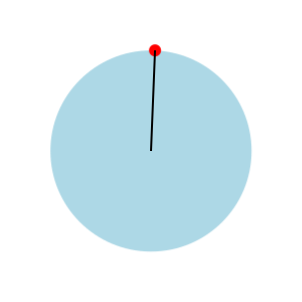

In [2]:
# If the problem is small enough, and 2D, we can even
# visualize the solution using Compose.jl and set
# the vector c with Interact.jl's sliders
using Compose, Interact
set_default_graphic_size(8cm, 8cm)

@manipulate for c1 in -1:0.1:+1, c2 in -1:0.1:+1, logϵ in -4:2
    sol, _ = solve_ball([c1,c2], 100, 10.0^logϵ)

    compose(context(),
    # Draw the solution vector
    compose(context(),
            line([(0.5,0.5),(0.5+sol[1]/300,0.5+sol[2]/300)]),
            stroke("black")),
    # Draw the intersection point
    compose(context(),
            circle((0.5 + (100/norm(sol))*sol/300)...,0.02),
            fill("red")),
    # Draw the feasible region
    compose(context(),circle(0.5,0.5,0.333),fill("lightblue"))
    )
end